In [1]:
import numpy as np

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

## Load dataset collected by running different configurations

In [2]:
data = []
labels = []

with open("../synthetic/data/titan_mlp.csv", encoding='UTF-8') as fileObject:
    next(fileObject)
    for line in fileObject:
        line_split = line.split(',')
        data.append(line_split[:-2])
        # there are two label: compilation_time and execution_time
        labels.append([line_split[-2], line_split[-1]])
        
# str -> float
X = []
for row in data:
    row = [float(x) for x in row]
    X.append(row)

y = np.array([[float(x[0]), float(x[1])] for x in labels])


# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=0)

print(f"train dataset length: {len(X_train)}")
print(f"test dataset length: {len(X_test)}")

train dataset length: 2332
test dataset length: 260


## Train two cost models

One is for compilation time prediction, the other is for execution time prediction.

In [3]:
# model for compilation_time prediction
compile_model = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=16, 
                         objective='reg:squarederror')
compile_model.fit(X_train, y_train[:, 0])

# on test dataset
compile_pred = compile_model.predict(X_test)
compile_mse = mean_squared_error(y_test[:, 0], compile_pred)
compile_mae = mean_absolute_error(y_test[:, 0], compile_pred)
compile_mape = mean_absolute_percentage_error(y_test[:, 0], compile_pred)
print(f"compilation MSE: {compile_mse}")
print(f"compilation MAE: {compile_mae}")
print(f"compilation MAPE: {compile_mape}")

compilation MSE: 59.95874808296463
compilation MAE: 2.1870894629221698
compilation MAPE: 0.03808066668333034


In [4]:
execution_model = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=10, 
                         objective='reg:squarederror')
execution_model.fit(X_train, y_train[:, 1])

execution_pred = execution_model.predict(X_test)
execution_mse = mean_squared_error(y_test[:, 1], execution_pred)
execution_mae = mean_absolute_error(y_test[:, 1], execution_pred)
execution_mape = mean_absolute_percentage_error(y_test[:, 1], execution_pred)
print(f"execution MSE: {execution_mse}")
print(f"execution MAE: {execution_mae}")
print(f"execution MAP: {execution_mape}")

execution MSE: 65.0381022396338
execution MAE: 2.499827673802009
execution MAP: 0.018980160757134913


## Feature Analysis

{'bytes acc': 105194.640625, 'bytes acc read': 7258.12109375, 'bytes acc write': 8933.4384765625, 'FLOPS': 2.9728846549987793, 'arithmetic intensity': 19347.150390625, 'dimension': 19215.17578125, '# of hidden': 12493334.0, 'width<=128': 16929.486328125, '128<width<=256': 8541.986328125, '256<width<=512': 3510.59375, 'width>512': 221.6451873779297, 'batch size': 119478.6796875, '# of time steps': 194842.1875, 'unroll': 102765752.0}


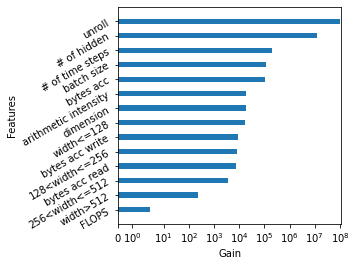

In [8]:
compile_model.get_booster().feature_names = ["bytes acc", "bytes acc read", 
"bytes acc read", "bytes acc write", "FLOPS", "arithmetic intensity", "# of params", "dimension", "# of hidden",
"width<=128", "128<width<=256", "256<width<=512", "width>512",
"batch size", "# of time steps", "unroll"]

print(compile_model.get_booster().get_score(importance_type='total_gain'))

fig, ax = plt.subplots(figsize=(4, 4))

plot_importance(compile_model, ax=ax,title=None, height=0.35, importance_type='total_gain', show_values=False, xlabel="Gain", grid=False)

ax.set_xscale("symlog")
ax.tick_params(labelrotation=30, axis='y', which='major')

plt.savefig('./pics/compile_model.pdf', format='pdf', dpi=300, pad_inches = 0, bbox_inches='tight')
plt.show()

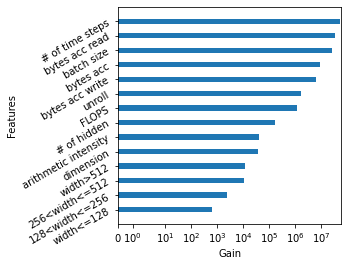

In [7]:
#  显示重要特征
execution_model.get_booster().feature_names = ["bytes acc", "bytes acc read", 
"bytes acc read", "bytes acc write", "FLOPS", "arithmetic intensity", "# of params", "dimension", "# of hidden",
"width<=128", "128<width<=256", "256<width<=512", "width>512",
"batch size", "# of time steps", "unroll"]

fig, ax = plt.subplots(figsize=(4, 4))

plot_importance(execution_model, ax=ax,title=None, height=0.35, importance_type='total_gain', show_values=False, xlabel="Gain", grid=False)

ax.set_xscale("symlog")
ax.tick_params(labelrotation=30, axis='y', which='major')

plt.savefig('./pics/run_model.pdf', format='pdf', dpi=300, pad_inches = 0, bbox_inches='tight')
plt.show()

## Save model

In [9]:
compile_model.save_model("./ckpt/titan_compile.txt")
execution_model.save_model("./ckpt/titan_execution.txt")

## Load checkpointed model

In [10]:
compile_model_loaded = xgb.XGBRegressor()
compile_model_loaded.load_model("./ckpt/titan_compile.txt")

execution_model_loaded = xgb.XGBRegressor()
execution_model_loaded.load_model("./ckpt/titan_execution.txt")

## Load Dataset of V100

In [11]:
data_v100 = []
labels_v100 = []

with open("../synthetic/data/v100_mlp.csv", encoding='UTF-8') as fileObject:
    next(fileObject)
    for line in fileObject:
        line_split = line.split(',')
        data_v100.append(line_split[:-2])
        labels_v100.append([line_split[-2], line_split[-1]])

X_v100 = []
for row in data_v100:
    row = [float(x) for x in row]
    X_v100.append(row)

y_v100 = np.array([[float(x[0]), float(x[1])] for x in labels_v100])

# train cost model
X_train_v100, X_test_v100, y_train_v100, y_test_v100 = train_test_split(X_v100, y_v100, 
                                                    test_size=0.2, 
                                                    random_state=0)

print(f"train length: {len(X_train_v100)}")
print(f"test length: {len(X_test_v100)}")

train length: 2073
test length: 519


## Without transfer learning

Just use model train with titan dataset and predict with v100 data.

In [12]:
compile_pred_v100 = compile_model_loaded.predict(X_test_v100)
compile_mse_v100 = mean_squared_error(y_test_v100[:, 0], compile_pred_v100)
compile_mae_v100 = mean_absolute_error(y_test_v100[:, 0], compile_pred_v100)
compile_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 0], compile_pred_v100)

print(f"compilation MSE: {compile_mse_v100}")
print(f"compilation MAE: {compile_mae_v100}")
print(f"compilation MAPE: {compile_mape_v100}")

execution_pred_v100 = execution_model_loaded.predict(X_test_v100)
execution_mse_v100 = mean_squared_error(y_test_v100[:, 1], execution_pred_v100)
execution_mae_v100 = mean_absolute_error(y_test_v100[:, 1], execution_pred_v100)
execution_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 1], execution_pred_v100)

print(f"execution MSE: {execution_mse_v100}")
print(f"execution MAE: {execution_mae_v100}")
print(f"execution MAPE: {execution_mape_v100}")

compilation MSE: 702.9539021701626
compilation MAE: 15.655904932977606
compilation MAPE: 0.23505191477555584
execution MSE: 705.2272184900032
execution MAE: 18.919900922646644
execution MAPE: 0.200787615782335


## Transfer learning + 518 Data

In [13]:
# the transfer model parameters should stay same with the original model
compile_model_transfer_2 = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=16, 
                         objective='reg:squarederror')


compile_model_transfer_2.fit(X_train_v100[:518], y_train_v100[:518][:, 0], xgb_model=compile_model_loaded)
# TODO: after collect all V100 data, fix the following line
compile_pred_v100 = compile_model_transfer_2.predict(X_test_v100)
compile_mse_v100 = mean_squared_error(y_test_v100[:, 0], compile_pred_v100)
compile_mae_v100 = mean_absolute_error(y_test_v100[:, 0], compile_pred_v100)
compile_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 0], compile_pred_v100)

print(f"compilation MSE: {compile_mse_v100}")
print(f"compilation MAE: {compile_mae_v100}")
print(f"compilation MAPE: {compile_mape_v100}")

execution_model_transfer_2 = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=10, 
                         objective='reg:squarederror')

execution_model_transfer_2.fit(X_train_v100[:518], y_train_v100[:518][:, 1], xgb_model=execution_model_loaded)
execution_pred_v100 = execution_model_transfer_2.predict(X_test_v100)
execution_mse_v100 = mean_squared_error(y_test_v100[:, 1], execution_pred_v100)
execution_mae_v100 = mean_absolute_error(y_test_v100[:, 1], execution_pred_v100)
execution_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 1], execution_pred_v100)

print(f"execution MSE: {execution_mse_v100}")
print(f"execution MAE: {execution_mae_v100}")
print(f"execution MAPE: {execution_mape_v100}")

compile_model_transfer_2.save_model("./ckpt/v100_518_compile.txt")
execution_model_transfer_2.save_model("./ckpt/v100_518_execution.txt")


compilation MSE: 48.27565915999874
compilation MAE: 2.1260542548001387
compilation MAPE: 0.03355020097510097
execution MSE: 92.18268425889497
execution MAE: 4.0552903168003915
execution MAPE: 0.026327003022744464


## Transfer Learning + 259 data

In [14]:
# the transfer model parameters should stay same with the original model
compile_model_transfer = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=16, 
                         objective='reg:squarederror')


compile_model_transfer.fit(X_train_v100[:259], y_train_v100[:259][:, 0], xgb_model=compile_model_loaded)
# TODO: after collect all V100 data, fix the following line
compile_pred_v100 = compile_model_transfer.predict(X_test_v100)
compile_mse_v100 = mean_squared_error(y_test_v100[:, 0], compile_pred_v100)
compile_mae_v100 = mean_absolute_error(y_test_v100[:, 0], compile_pred_v100)
compile_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 0], compile_pred_v100)

print(f"compilation MSE: {compile_mse_v100}")
print(f"compilation MAE: {compile_mae_v100}")
print(f"compilation MAPE: {compile_mape_v100}")

execution_model_transfer = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=10, 
                         objective='reg:squarederror')

execution_model_transfer.fit(X_train_v100[:259], y_train_v100[:259][:, 1], xgb_model=execution_model_loaded)
execution_pred_v100 = execution_model_transfer.predict(X_test_v100)
execution_mse_v100 = mean_squared_error(y_test_v100[:, 1], execution_pred_v100)
execution_mae_v100 = mean_absolute_error(y_test_v100[:, 1], execution_pred_v100)
execution_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 1], execution_pred_v100)

print(f"execution MSE: {execution_mse_v100}")
print(f"execution MAE: {execution_mae_v100}")
print(f"execution MAPE: {execution_mape_v100}")

compile_model_transfer.save_model("./ckpt/v100_259_compile.txt")
execution_model_transfer.save_model("./ckpt/v100_259_execution.txt")

compilation MSE: 66.01570466174127
compilation MAE: 3.1560450900267085
compilation MAPE: 0.043117325112783586
execution MSE: 161.53200148953047
execution MAE: 5.532641458603229
execution MAPE: 0.03649891354842079


## Without transfer learning, train the model from scratch

In [17]:
compile_model_v100 = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=16, 
                         objective='reg:squarederror')

compile_model_v100.fit(X_train_v100, y_train_v100[:, 0])
compile_pred_v100 = compile_model_v100.predict(X_test_v100)
compile_mse_v100 = mean_squared_error(y_test_v100[:, 0], compile_pred_v100)
compile_mae_v100 = mean_absolute_error(y_test_v100[:, 0], compile_pred_v100)
compile_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 0], compile_pred_v100)

print(f"compilation MSE: {compile_mse_v100}")
print(f"compilation MAE: {compile_mae_v100}")
print(f"compilation MAPE: {compile_mape_v100}")

execution_model_v100 = xgb.XGBRegressor(n_estimators=128, 
                         learning_rate=0.05, 
                         max_depth=10, 
                         objective='reg:squarederror')

execution_model_v100.fit(X_train_v100, y_train_v100[:, 1])
execution_pred_v100 = execution_model_v100.predict(X_test_v100)
execution_mse_v100 = mean_squared_error(y_test_v100[:, 1], execution_pred_v100)
execution_mae_v100 = mean_absolute_error(y_test_v100[:, 1], execution_pred_v100)
execution_mape_v100 = mean_absolute_percentage_error(y_test_v100[:, 1], execution_pred_v100)

print(f"execution MSE: {execution_mse_v100}")
print(f"execution MAE: {execution_mae_v100}")
print(f"execution MAPE: {execution_mape_v100}")

compile_model_v100.save_model("./ckpt/v100_compile.txt")
execution_model_v100.save_model("./ckpt/v100_execution.txt")

compilation MSE: 25.812740301368365
compilation MAE: 1.552496922039113
compilation MAPE: 0.022822788186998594
execution MSE: 63.1931381668236
execution MAE: 2.9898683184144126
execution MAPE: 0.020536728632092136
